In [1]:
!pip install -q fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 5.4 MB/s eta 0:00:00:00:01


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from fairlearn.metrics import selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.preprocessing import CorrelationRemover

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.options.display.max_columns=500


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()

In [3]:
# data = fetch_openml(data_id=1590, as_frame=True)
#data = fetch_adult()
data = pd.read_csv("/kaggle/input/loan-prediction-practice-av-competition/train_csv.csv")
data = data.rename({"Gender":"sex","Loan_Status":"target", "Property_Area":"race"},axis=1)
data.drop("Loan_ID",axis=1,inplace=True)

X = data
y = (data.target == 'Y') * 1
sex = data['sex']
race =data['race']
X_raw = data
A = X_raw["sex"]

df = pd.concat([X,pd.Series(y, name='>50K')], axis=1)

df.drop("target",axis=1,inplace=True)

In [ ]:
df.head()

In [5]:
df['sex']=label_encoder.fit_transform(df['sex'])
df['Married']=label_encoder.fit_transform(df['Married'])
df['Education']=label_encoder.fit_transform(df['Education'])
df['Self_Employed']=label_encoder.fit_transform(df['Self_Employed'])
df['race']=label_encoder.fit_transform(df['race'])
df['Dependents']=label_encoder.fit_transform(df['Dependents'])

In [ ]:
df.head()

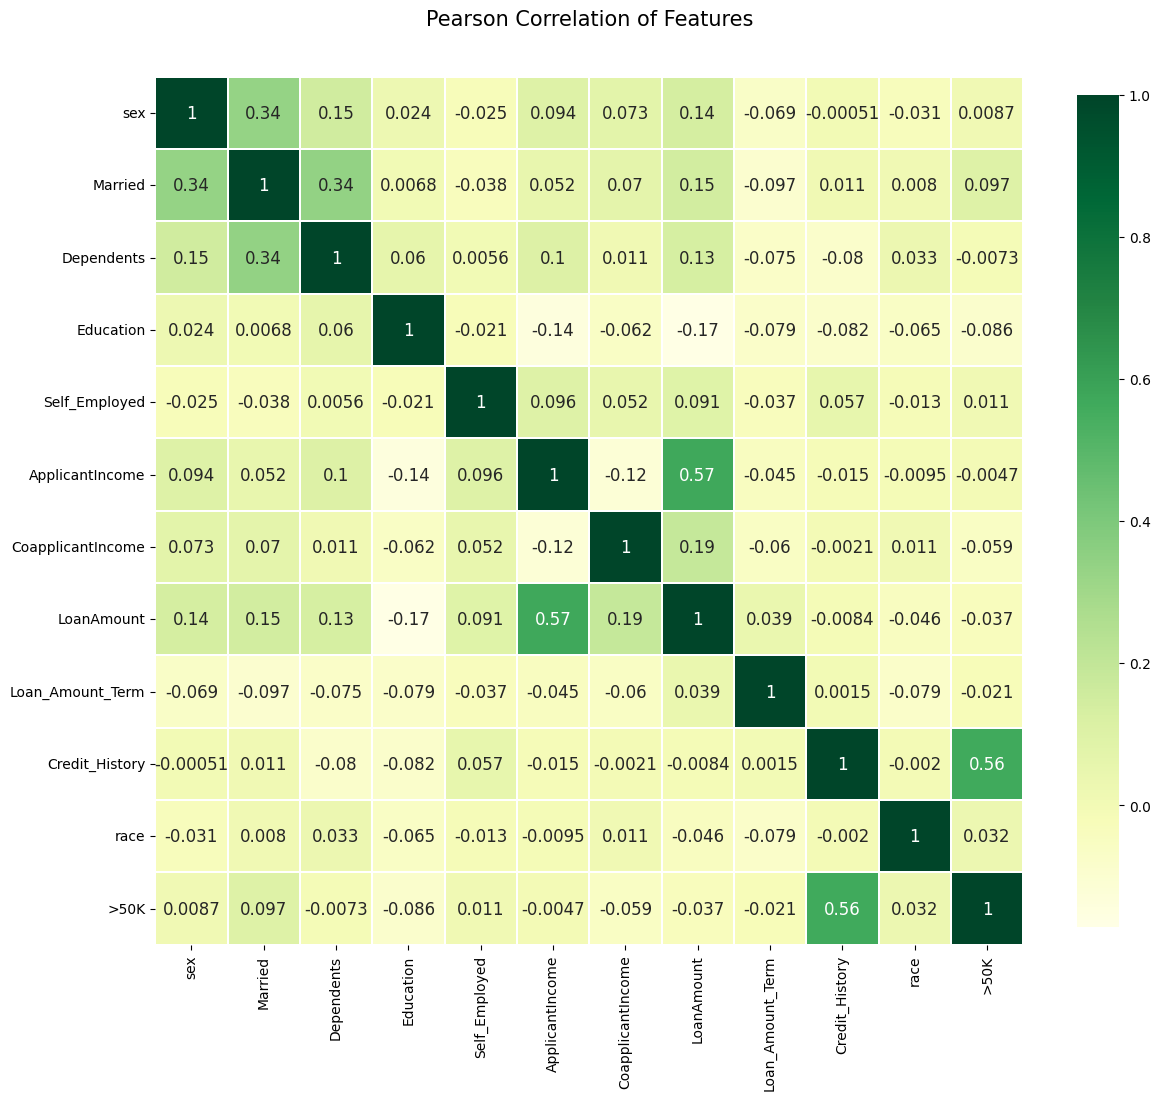

In [8]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = "YlGn",
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df)

# Our Model

In [7]:
X=df.drop('>50K',axis=1)
y=df['>50K']

In [10]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np

y_pred = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
classifier = CatBoostClassifier(verbose=0)

for train_idx, val_idx in skf.split(X, y):
    classifier.fit(X.loc[train_idx,:], y[train_idx])
    y_pred[val_idx] = classifier.predict(X.loc[val_idx,:])


## Fairness Assessment for the model 

# Metrics

In [11]:
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
}

# -   Sex as Sensitive Feature 

In [ ]:
model_Assessmt_sex = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=df['sex'])
model_Assessmt_sex.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
    ylim=[0.6,1.0]
   
)
print(model_Assessmt_sex.overall)
print(model_Assessmt_sex.by_group)

# -   Race as Sensitive Feature 

In [ ]:
model_Assessmt_race = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=df['sex'])
model_Assessmt_race.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
    ylim=[0.6,1.0]
   
)


# -   Race Plus Sex as Sensitive Feature

In [ ]:
mfm = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=df[['sex','race']])
mfm.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
   
)

In [ ]:
print(mfm.overall)

# 2.   Democratic Parity Differences

## 2.1 Democratic Parity Differences for Sex

In [ ]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred,
                                    sensitive_features=df['sex']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred,
                               sensitive_features=df['sex']))

## 2.2 Democratic Parity Differences for Race

In [ ]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred,
                                    sensitive_features=df['race']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred,
                               sensitive_features=df['race']))

## 2.3 Democratic Parity Differences for Sex Plus Race

In [ ]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred,
                                    sensitive_features=df[['sex','race']]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred,
                               sensitive_features=df[['sex','race']]))

## 2.4  Heatmap and bar chart for Democratic Parity Differences 

In [ ]:
data_diffrances=[[0.17,0.30],[0.30,0.17]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
data_diagonal={'sex':0.17, 'race':0.17}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')

plt.show()

#                               3. MITIGATION 

## 3.1 Parallel Mitigation 

-    Executing Matigation Algorithms independently from each other.  

# 1)  Pre-processing

##   A- CorrelationRemover

 ###   a ) Sex as Sensitive Feature

In [19]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np

crp_sex = CorrelationRemover(sensitive_feature_ids=['sex'])
crp_sex.fit(X.fillna(0))
X_transform_sexp = crp_sex.transform(X.fillna(0))

y_pred_sexp = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
classifier = CatBoostClassifier(verbose=0)

for train_idx, val_idx in skf.split(X_transform_sexp, y):
    classifier.fit(X_transform_sexp[train_idx], y[train_idx])
    y_pred_sexp[val_idx] = classifier.predict(X_transform_sexp[val_idx])


 ###   b ) Testing Fairness

In [ ]:
Metric_Corr_Para_sex = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred_sexp,
                           sensitive_features= df['sex'])
Metric_Corr_Para_sex.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)
print(Metric_Corr_Para_sex.overall)

 ###   c ) Race as Sensitive Feature

In [21]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np

crp_sex = CorrelationRemover(sensitive_feature_ids=['race'])
crp_sex.fit(X.fillna(0))
X_transform_sexp = crp_sex.transform(X.fillna(0))

y_pred_racep = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
classifier = CatBoostClassifier(verbose=0)

for train_idx, val_idx in skf.split(X_transform_sexp, y):
    classifier.fit(X_transform_sexp[train_idx], y[train_idx])
    y_pred_racep[val_idx] = classifier.predict(X_transform_sexp[val_idx])


 ###   d ) Testing Fairness

In [ ]:
Metric_Corr_Para_race = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred_racep,
                           sensitive_features= df[['race']])
Metric_Corr_Para_race.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

 ###   e ) Race&Sex as Sensitive Feature

In [23]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np

crp_sex = CorrelationRemover(sensitive_feature_ids=['race'])
crp_sex.fit(X.fillna(0))
X_transform_sexp = crp_sex.transform(X.fillna(0))

y_pred_racesexp = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
classifier = CatBoostClassifier(verbose=0)

for train_idx, val_idx in skf.split(X_transform_sexp, y):
    classifier.fit(X_transform_sexp[train_idx], y[train_idx])
    y_pred_racesexp[val_idx] = classifier.predict(X_transform_sexp[val_idx])


In [ ]:
Metric_Corr_Para_racesex = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred_racesexp,
                           sensitive_features= df[['race','sex']])
Metric_Corr_Para_racesex.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
print(Metric_Corr_Para_racesex.overall)

# B) Democratic Parity Differences 


 ###   a ) Sex as Sensitive Feature

In [ ]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_sexp,
                                    sensitive_features=df['sex']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_sexp,
                               sensitive_features=df['sex']))

 ###   b ) Race as Sensitive Feature

In [ ]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_racep,
                                    sensitive_features=df["race"]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_racep,
                               sensitive_features=df["race"]))

 ###   c ) Race&Sex as Sensitive Feature

In [ ]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_racesexp,
                                    sensitive_features=df[["race",'sex']]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_racesexp,
                               sensitive_features=df[["race",'sex']])) 

## Heat map for Democratic Parity Differences for sex and race After Removing Possible Correlation

In [ ]:
data_diffrances=[[0.17,0.22],[0.22,0.17]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

#  2 )  In-processing

## 2.1 ExponentiatedGradient

 ###   a ) Sex as Sensitive Feature

In [32]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
np.random.seed(0)


y_pred_mitigatedP = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X, y):
    constraint = DemographicParity()
    classifier = CatBoostClassifier(verbose=0)
    classifier = ExponentiatedGradient(classifier, constraint)
    classifier.fit(X.loc[train_idx,:], y[train_idx], sensitive_features=X.loc[train_idx,:][['sex']])
    y_pred_mitigatedP[val_idx] = classifier.predict(X.loc[val_idx,:])


In [ ]:
eg_sex_mitigated = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred_mitigatedP, sensitive_features=df[['sex']])


eg_sex_mitigated.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
print(eg_sex_mitigated.overall)
print(eg_sex_mitigated.by_group)

 ###   b ) race as Sensitive Feature

In [36]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
np.random.seed(0)


y_pred_mitigatedP_r = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X, y):
    constraint = DemographicParity()
    classifier = CatBoostClassifier(verbose=0)
    classifier = ExponentiatedGradient(classifier, constraint)
    classifier.fit(X.loc[train_idx,:], y[train_idx], sensitive_features=X.loc[train_idx,:][['race']])
    y_pred_mitigatedP_r[val_idx] = classifier.predict(X.loc[val_idx,:])


In [ ]:
eg_race_mitigated = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred_mitigatedP_r, sensitive_features=df[['race']])


eg_race_mitigated.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

###   c ) race&sex as Sensitive Feature

In [38]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
np.random.seed(0)


y_pred_mitigatedp_rs = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X, y):
    constraint = DemographicParity()
    classifier = CatBoostClassifier(verbose=0)
    classifier = ExponentiatedGradient(classifier, constraint)
    classifier.fit(X.loc[train_idx,:], y[train_idx], sensitive_features=X.loc[train_idx,:][['race','sex']])
    y_pred_mitigatedp_rs[val_idx] = classifier.predict(X.loc[val_idx,:])


In [ ]:
rst_mitigatedp = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred_mitigatedp_rs, sensitive_features=df[['race','sex']])


rst_mitigatedp.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
print(rst_mitigatedp.overall)


## 2.2 Democratic Parity Differences 

 ###   a ) Sex as Sensitive Feature

In [ ]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_mitigatedP,
                                    sensitive_features=df['sex']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_mitigatedP,
                               sensitive_features=df['sex']))

 ###   b ) race as Sensitive Feature

In [ ]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_mitigatedP_r,
                                    sensitive_features=df["race"]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_mitigatedP_r,
                               sensitive_features=df["race"]))

 ###   c ) race&sex as Sensitive Feature

In [ ]:

from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_mitigatedp_rs,
                                    sensitive_features=df[["race",'sex']]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_mitigatedp_rs,
                               sensitive_features=df[["race",'sex']]))

## Heat map for Democratic Parity Differences for sex and race Mitigation 

In [ ]:
data_diffrances=[[0.02,0.05],[0.05,0.02]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

# 2.3 GridSearch 

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from fairlearn.reductions import DemographicParity, GridSearch, EqualizedOdds

 ###   a ) Sex as Sensitive Feature

In [60]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
np.random.seed(0)


y_pred_GSp_sex_mitigated = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X, y):
    constraint = DemographicParity()
    classifier = CatBoostClassifier(verbose=0)
    classifier = GridSearch(classifier, constraint,grid_size=31)
    classifier.fit(X.loc[train_idx,:], y[train_idx], sensitive_features=X.loc[train_idx,:][['sex']])
    y_pred_GSp_sex_mitigated[val_idx] = classifier.predict(X.loc[val_idx,:])


In [ ]:
GS_mitigatedp_sex = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred_GSp_sex_mitigated, sensitive_features=df[['sex']])
GS_mitigatedp_sex.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
   title="Show all metrics",
)

In [ ]:
print(GS_mitigatedp_sex.overall)


 ###   Sex&race as Sensitive Feature

In [52]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
np.random.seed(0)


y_pred_GSp_sexrace_mitigated = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X, y):
    constraint = DemographicParity()
    classifier = CatBoostClassifier(verbose=0)
    classifier = GridSearch(classifier, constraint,grid_size=31)
    classifier.fit(X.loc[train_idx,:], y[train_idx], sensitive_features=X.loc[train_idx,:][['race','sex']])
    y_pred_GSp_sexrace_mitigated[val_idx] = classifier.predict(X.loc[val_idx,:])


In [ ]:
 GS_mitigatedp_sexrace = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred_GSp_sexrace_mitigated, sensitive_features=df[["race",'sex']])
GS_mitigatedp_sexrace.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
   title="Show all metrics",
)

In [ ]:
print(GS_mitigatedp_sexrace.overall)


## 2.4 Democratic Parity Differences 

 ###    Sex as Sensitive Feature

In [ ]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_GSp_sex_mitigated,
                                    sensitive_features=df['sex']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_GSp_sex_mitigated,
                               sensitive_features=df['sex']))

 ###   Sex&race as Sensitive Feature

In [ ]:

from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_GSp_sexrace_mitigated,
                                    sensitive_features=df[["race",'sex']]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_GSp_sexrace_mitigated,
                               sensitive_features=df[["race",'sex']]))

#  3 )  Post-processing

# 3.1 - ThresholdOptimizer

In [9]:
from fairlearn.postprocessing import ThresholdOptimizer

 ###  a ) sex as Sensitive Feature

In [65]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
np.random.seed(0)


thp_sex_y_pred = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X, y):
    classifier = CatBoostClassifier(verbose=0)
    classifier = ThresholdOptimizer(estimator=classifier, constraints='demographic_parity')
    classifier.fit(X.loc[train_idx,:], y[train_idx], sensitive_features=X.loc[train_idx,:][['sex']])
    thp_sex_y_pred[val_idx] = classifier.predict(X.loc[val_idx,:], sensitive_features=X.loc[val_idx,:][['sex']])


In [ ]:
metric_frame_thp_sex = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=thp_sex_y_pred,
                           sensitive_features=df[['sex']])
metric_frame_thp_sex.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
print(metric_frame_thp_sex.overall)


## 3.2 Democratic Parity Differences 

In [ ]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=thp_sex_y_pred,
                                    sensitive_features=df['sex']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=thp_sex_y_pred,
                               sensitive_features=df['sex']))

# 3.2 Mitigation in Series 

# 1 ) CorrelationRemover + ExponentiateGradient

In [ ]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tqdm import tqdm

crp_sex = CorrelationRemover(sensitive_feature_ids=['sex'])
crp_sex.fit(X.fillna(0))
X_transform_sexp = crp_sex.transform(X.fillna(0))

y_pred_mitigated_sex_s = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
classifier = CatBoostClassifier(verbose=0)

for train_idx, val_idx in tqdm(skf.split(X_transform_sexp, y)):
    constraint = DemographicParity()
    classifier = CatBoostClassifier(verbose=0)
    classifier = ExponentiatedGradient(classifier, constraint,max_iter=10)
    classifier.fit(X_transform_sexp[train_idx], y[train_idx], sensitive_features=X.loc[train_idx,:][['sex']])
    y_pred_mitigated_sex_s[val_idx] = classifier.predict(X_transform_sexp[val_idx])


In [ ]:
dmpds = demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_mitigated_sex_s,
                                    sensitive_features=df['sex'])
dmpds

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y,y_pred_mitigated_sex_s)

 # 2 ) CorrelationRemover + GridSearch

In [ ]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tqdm import tqdm

crp_sex = CorrelationRemover(sensitive_feature_ids=['sex'])
crp_sex.fit(X.fillna(0))
X_transform_sexp = crp_sex.transform(X.fillna(0))

y_pred_GS_mitigated_sex_scg = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
classifier = CatBoostClassifier(verbose=0)

for train_idx, val_idx in tqdm(skf.split(X_transform_sexp, y)):
    constraint = DemographicParity()
    classifier = CatBoostClassifier(verbose=0)
    classifier = GridSearch(classifier, constraint,grid_size=31*5)
    classifier.fit(X_transform_sexp[train_idx], y[train_idx], sensitive_features=X.loc[train_idx,:][['sex']])
    y_pred_GS_mitigated_sex_scg[val_idx] = classifier.predict(X_transform_sexp[val_idx])


In [ ]:
dmpds = demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_GS_mitigated_sex_scg,
                                    sensitive_features=df['sex'])
dmpds
# 0.3278275916312726

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y,y_pred_GS_mitigated_sex_scg)

# 3 ) CorrelationRemover + ThresholdOptimizer

In [10]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np

crp_sex = CorrelationRemover(sensitive_feature_ids=['sex'])
crp_sex.fit(X.fillna(0))
X_transform_sexp = crp_sex.transform(X.fillna(0))

th_sex_y_pred_sct = np.zeros(len(y))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
classifier = CatBoostClassifier(verbose=0)

for train_idx, val_idx in skf.split(X_transform_sexp, y):
    constraint = DemographicParity()
    classifier = CatBoostClassifier(verbose=0)
    classifier = ThresholdOptimizer(estimator=classifier, constraints='demographic_parity')
    classifier.fit(X.loc[train_idx,:], y[train_idx], sensitive_features=X.loc[train_idx,:][['sex']])
    th_sex_y_pred_sct[val_idx] = classifier.predict(X.loc[val_idx,:], sensitive_features=X.loc[val_idx,:][['sex']])


In [ ]:
from fairlearn.metrics import demographic_parity_difference
dmpds = demographic_parity_difference(y_true=y,
                                    y_pred=th_sex_y_pred_sct,
                                    sensitive_features=df['sex'])
dmpds

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y,th_sex_y_pred_sct)